In [0]:
 import time
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import sklearn as skl
from xgboost import plot_tree
import seaborn as sns
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import os, ssl
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
%config InlineBackend.figure_format = 'png'
%matplotlib inline

## Problem 1: Multi-class Classification – MNIST.
In this exercise you will explore the MNIST data set which you will find here: https://www.openml.org/d/554. MNIST is a data set of handwritten digits, and is considered one of the “easiest” image recognition problems in computer vision.

• Use the fetch openml command from sklearn.datasets to import the MNIST data set,

• Use Random Forests to try to get the best possible test accuracy on MNIST. This involves getting acquainted with how Random Forests work, understanding their parameters, and therefore using Cross Validation to find the best settings. How well can you do? You should use the accuracy metric, since this is what you used in Lab 5 – therefore this will allow you to compare your results from Random Forests with your results from L1- and L2- Regularized Logistic Regression. What are the hyperparameters of your best model?

• Use Boosting to do the same. Take the time to understand how XGBoost works (and/or other boosting packages available). Try your best to tune your hyper-parameters. As added motivation: typically the winners and near-winners of the Kaggle competition are those that are best able to tune an cross validate XGBoost. What are the hyperparameters of your best model?

• (Optional) Run multi-class logistic regression on these using the cross entropy loss. You may have to play around with the hyperparameters (especially the tolerance) to get it to converge in a reasonable amount of time. I recommend the SAGA solver. Try to optimize the hyperparameters. Report your training and test loss from above,

• (Optional) Choose an `1 regularizer (penalty), and see if you can get a sparse solution with almost as good accuracy.

• (Optional) Note that in Logistic Regression, the coefficients returned (i.e., the β’s) are the same dimension as the data. Therefore we can pretend that the coefficients of the solution are an image of the same dimension, and plot it. Do this for the 10 sets of coefficients that correspond to the 10 classes. You should observe that, at least for the sparse solutions, these “kind of” look like the digits they are classifying.

Sparsity with L1 penalty: 80.42%
Test score with L1 penalty: 0.8343


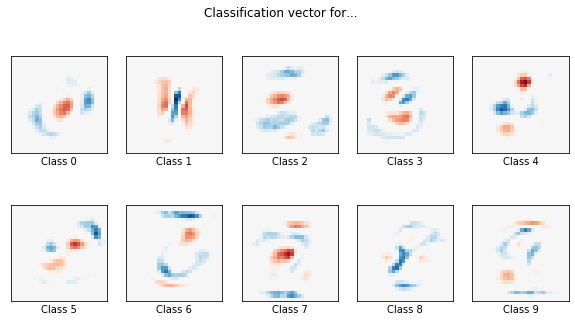

In [2]:
t0 = time.time()
train_samples = 5000
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / train_samples,multi_class='multinomial',penalty='l1', solver='saga', tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
  l1_plot = plt.subplot(2, 5, i + 1)
  l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest', cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
  l1_plot.set_xticks(())
  l1_plot.set_yticks(())
  l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
run_time = time.time() - t0
plt.show()

In [4]:
#Predicted Values
y_predicted = clf.predict(X_test)
print("Accuracy: %.2f" % accuracy_score(y_test, y_predicted))
#Probabilities of Predicted Values
y_predProb = clf.predict_proba(X_test)
y_predProbTraining = clf.predict_proba(X_train)
#create y_truedist array with probability 1 for actual digit
y_truedist = np.zeros((10000,10))
dig = 0
for i in range(10000):
  dig = int(y_test[i])
  y_truedist[i,dig] = 1

loss = log_loss(y_test.reshape(-1,1),y_predProb, labels = ['0','1','2','3','4','5','6','7','8','9'])
lossTraining = log_loss(y_train.reshape(-1,1),y_predProbTraining, labels = ['0','1','2','3','4','5','6','7','8','9'])
print("Test Loss with L1 penalty: %.2f" % loss)
print("Training Loss with L1 penalty: %.2f" % lossTraining)


Accuracy: 0.83
Test Loss with L1 penalty: 0.83
Training Loss with L1 penalty: 0.81


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Sparsity without L1 penalty: 16.07%
Test score without L1 penalty: 0.8841


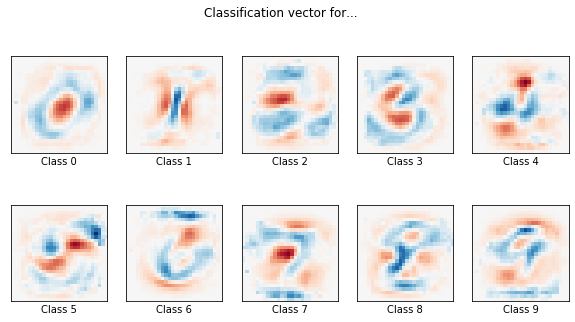

In [5]:
clf2 = LogisticRegression(C=50. / train_samples,
 multi_class='multinomial',
 penalty='none', solver='saga', tol=0.1)
clf2.fit(X_train, y_train)
sparsity = np.mean(clf2.coef_ == 0) * 100
score = clf2.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity without L1 penalty: %.2f%%" % sparsity)
print("Test score without L1 penalty: %.4f" % score)
coef = clf2.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
  l1_plot = plt.subplot(2, 5, i + 1)
  l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest', cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
  l1_plot.set_xticks(())
  l1_plot.set_yticks(())
  l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
run_time = time.time() - t0
plt.show()


In [6]:
#Predicted Values
y_predicted2 = clf2.predict(X_test)
print("Accuracy: %.2f" % accuracy_score(y_test, y_predicted2))
#Probabilities of Predicted Values
y_predProb2 = clf2.predict_proba(X_test)
y_predProb2Training = clf2.predict_proba(X_train)
loss2 = log_loss(y_test.reshape(-1,1),y_predProb2, labels = ['0','1','2','3','4','5','6','7','8','9'])
loss2Training = log_loss(y_train.reshape(-1,1),y_predProb2Training, labels = ['0','1','2','3','4','5','6','7','8','9'])
print("Test Loss without L1 penalty: %.2f" % loss2)
print("Training loss without L1 penalty: %.2f" % loss2Training)

Accuracy: 0.88
Test Loss without L1 penalty: 0.44
Training loss without L1 penalty: 0.42


In [7]:
# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42, max_depth = 5)
rf.fit(X_train, y_train)
y_predRF = rf.predict(X_test)
print("Accuracy: %.2f" % accuracy_score(y_test, y_predRF))


Accuracy: 0.87


In [9]:
#Time to Tune
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf,
 'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000]}


In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 59.6min finished


{'n_estimators': 1336, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [10]:
rfBest = RandomForestClassifier(n_estimators = 231, random_state = 42, max_depth = None, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt',bootstrap = False)
rfBest.fit(X_train, y_train)
y_predBestRF = rfBest.predict(X_test)
print("Accuracy: %.2f" % accuracy_score(y_test, y_predBestRF))
print("This accuracy is really good")

Accuracy: 0.95
This accuracy is really good


In [12]:
#XGBoost
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg_model.fit(X_train,y_train)
preds = xg_model.predict(X_test)
print("Accuracy: %.2f" % accuracy_score(y_test, preds))


Accuracy: 0.90


In [13]:
xg_model2 = xgb.XGBClassifier()
parameters = {
 "eta" : [0.10, 0.20, 0.30 ] ,
 "max_depth" : [ 5, 10, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma" : [ 0.0, 0.2 , 0.4 ],
 "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
 }
xgb_random = RandomizedSearchCV(estimator = xg_model2, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)
print(xgb_random.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 116.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 220.4min finished


{'min_child_weight': 3, 'max_depth': 10, 'gamma': 0.0, 'eta': 0.1, 'colsample_bytree': 0.3}


In [14]:
xgb_best = xgb.XGBClassifier(min_child_weight = 3, max_depth = 15, gamma = 0.2, eta = 0.3, colsample_bytree = 0.3)
xgb_best.fit(X_train,y_train)
bestPreds = xgb_best.predict(X_test)
print("Accuracy: %.2f" % accuracy_score(y_test, bestPreds))


Accuracy: 0.94


The Randomized Search XGBoost accuracy is about as good as the Randomized Search Random Forest accuracy. For further improvement, more parameters can be inputted into the randomized search.

## Problem 2: CIFAR-10.
In this problem you will explore the data set CIFAR-10, just as you did above for MNIST. Now that you have your pipeline set up, it should be easy to apply the above procedure to CIFAR-10.
If you did something that takes significant computation time, keep in mind that CIFAR-10 is a few times larger.

• (Optional) You can read about the CIFAR-10 and CIFAR-100 data sets here: https://www.cs.toronto.edu/~kriz/cifar.html.

• (Optional) OpenML curates a number of data sets. You will use a subset of CIFAR-10 provided by them. Read here for a description: https://www.openml.org/d/40926.

• Use the fetch openml command from sklearn.datasets to import the CIFAR-10-Small data set.

• Figure out how to display some of the images in this data set, and display a couple. While not high resolution, these should be recognizable if you are doing it correctly.

• What is the best accuracy you can get on the test data, by tuning Random Forests? What are the hyperparameters of your best model?

• What is the best accuracy you can get on the test data, by tuning XGBoost? What are the hyperparameters of your best model?

• (Optional) You will run multi-class logistic regression on these using the cross entropy loss. You have to specify this specifically (multi class=’multinomial’). Use cross validation to see how good your accuracy can be. In this case, cross validate to find as good regularization coefficients as you can, for `1 and `2 regularization (called penalties), which are naturally supported in sklearn.linear model.LogisticRegression. As with MNIST, I recommend you use the solver saga.

• (Optional) Report your training and test loss from above,

• (Optional) How sparse can you make your solutions without deteriorating your testing error too much? Here, I am asking you to try to obtain a sparse solution that has test accuracy that is close to the best solution you found.

In [5]:
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
 ssl._create_default_https_context = ssl._create_unverified_context
data = fetch_openml("CIFAR_10_small")
pics = data['data']
label = data['target']
X_train = pics[18000:]
y_train = label[18000:]
rf = RandomForestClassifier(n_estimators= 500, random_state = 42, max_depth=5)
rf.fit(X_train, y_train)
y_predRF = rf.predict(pics[:1000])
y_true = label[:1000]
print(skl.metrics.accuracy_score(y_true, y_predRF))

0.338


In [6]:
random_grid = {
 'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)],
 'min_samples_split': [2,5,10],
 'min_samples_leaf': [1,2,4],
 'bootstrap': [True, False]
}
rf2 = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 92.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 194.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [7]:
rf_random.best_params_


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1778}

In [9]:
rf3 = RandomForestClassifier(n_estimators= 894, max_depth=70, min_samples_split=2, min_samples_leaf=2, max_features='auto', bootstrap=False)
rf3.fit(X_train, y_train)
y_predRF3 = rf.predict(pics[:1000])
y_true = label[:1000]
print(skl.metrics.accuracy_score(y_true, y_predRF3))

0.338


In [0]:
# specify parameters via map
#param = {'max_depth':2, 'eta':1, 'objective':'multi:softprob', 'num_class':10}
#num_round = 30
model = xgb.XGBClassifier(colsample_bytree=.3, max_depth=5, learning_rate=.1, n_estimators=300, alpha=10)
#bst = xgb.train(param, dtrain, num_round)
# make prediction
#preds = bst.predict(dtest)
#best_preds = np.asarray([np.argmax(line) for line in preds])
clf = xgb.XGBClassifier()
parameters = {
 "eta" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15]
 }
grid = GridSearchCV(clf, parameters, n_jobs=4, scoring="neg_log_loss", cv=3)
grid.fit(X_train, y_train)
model.fit(pics[18000:], label[18000:])


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [9]:
preds = model.predict(pics[:1000])
y_true = label[:1000]
print(skl.metrics.accuracy_score(y_true, preds))
for i in range(0,5):
  print(preds[i])
  print(label[i])

0.353
6
6
8
9
9
9
6
4
9
1


In [0]:
# dump model with feature map
bst.dump_model('dump.raw.txt')

## Problem 3: Revisiting Kaggle.
1. (From PS 3) Lets start with our first Kaggle submission in a playground regression competition. Make an account to Kaggle and find https://www.kaggle.com/c/house-prices-advancedregression-techniques/
2. (From PS 3) Follow the data preprocessing steps from https://www.kaggle.com/apapiu/houseprices-advanced-regression-techniques/regularized-linear-models. Then run a ridge regression using α = 0.1. Make a submission of this prediction, what is the RMSE you get?
(Hint: remember to exponentiate np.expm1(ypred) your predictions).
3. (From PS 3) Compare a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?
4. (From PS 3) Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the strength of regularization parameter alpha.
5. (From PS 3) Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking). Be careful not to overfit. What score can you get? (We will be discussing ensembling more, later in the class, but you can start playing with it now).
6. Train a gradient boosting regression, e.g., using XGBoost. What score can you get just from a single XGB? (you will need to optimize over its parameters). We will discuss boosting and gradient boosting in more detail later. XGB is a great friend to all good Kagglers!
7. Do your best to get the more accurate model. Try feature engineering and stacking many models. You are allowed to use any public tool in python. No non-python tools allowed.
8. Read the Kaggle forums, tutorials and Kernels in this competition. This is an excellent way to learn. Include in your report if you find something in the forums you like, or if you made your own post or code post, especially if other Kagglers liked or used it afterwards.
9. Be sure to read and learn the rules of Kaggle! No sharing of code or data outside the Kaggle forums. Every student should have their own individual Kaggle account and teams can be formed in the Kaggle submissions with your Lab partner. This is more important for live competitions of course.
10. As in the real in-class Kaggle competition (which will be next), you will be graded based on your public score (include that in your report) and also on the creativity of your solution. In your report (that you will submit as a pdf file), explain what worked and what did not work. Many creative things will not work, but you will get partial credit for developing them. We will invite teams with interesting solutions to present them in class.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
path = '/content/gdrive/My Drive/Colab Notebooks/TA/'
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c3eca518>,
      dtype=object)

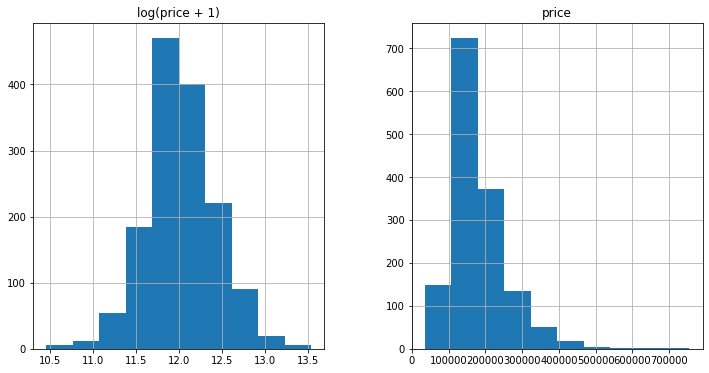

In [8]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice



In [0]:
def rmse_cv(model):
  rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
  return(rmse)

In [12]:
model_ridge = Ridge(alpha=.1)
model_ridge.fit(X_train,y)
ypred = model_ridge.predict(X_test)
preds = np.expm1(ypred)
solution = pd.DataFrame({"Id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_alpha_0.1_predictions.csv", index=False)
print("The RMSE that we get from the Kaggle submission for ridge where alpha = 0.1 is 0.13029")


The RMSE that we get from the Kaggle submission for ridge where alpha = 0.1 is 0.13029


In [13]:
model_lasso = Lasso(alpha=.1)
model_lasso.fit(X_train, y)
ypreds_lasso = model_lasso.predict(X_test)
preds_lasso = np.expm1(ypreds_lasso)
solution_lasso = pd.DataFrame({"Id":test.Id, "SalePrice":preds_lasso})
solution_lasso.to_csv("lasso_alpha_0.1_predictions.csv", index=False)
print("The RMSE from Lasso with alpha 0.1 is 0.21524, which is worse than that of Ridge")


The RMSE from Lasso with alpha 0.1 is 0.21524, which is worse than that of Ridge


In [14]:
best_ridge_model = RidgeCV(cv = 10).fit(X_train, y)
print("best ridge alpha: " + str(best_ridge_model.alpha_))
print("rmse: " + str(rmse_cv(Ridge(alpha = 10))) )
#9[0.1111859 0.13654828 0.12645879 0.11035735 0.15220962]
#10 [0.11116 0.13661429 0.12633911 0.11040789 0.15216544]
best_lasso_model = LassoCV(cv = 10).fit(X_train, y)
print("best lasso alpha: " + str(best_lasso_model.alpha_))
print("rmse: " + str(rmse_cv(Lasso(alpha = 0.055550459907637594))) )
#0.004255390487105146[0.12333986 0.14803492 0.14207026 0.1238079 0.16408229] //np,log1p(y)
#0.055550459907637594 [0.17363849 0.19384209 0.18222106 0.17812859 0.203844 ]
##Ridge##
model_ridge = RidgeCV()
model_ridge.fit(X_train,y)
print("best ridge alpha: " + str(model_ridge.alpha_) + " result: " + str(0.12224))
ypred = model_ridge.predict(X_test)
preds = np.expm1(ypred)
solution = pd.DataFrame({"Id":test.Id, "SalePrice":preds})
solution.to_csv("ridgeCV_alpha_10_predictions.csv", index=False)
##Lasso##
model_lasso = LassoCV()
model_lasso.fit(X_train, y)
print("best lasso alpha: " + str(model_lasso.alpha_) + " result: " + str(0.19136))
ypreds_lasso = model_lasso.predict(X_test)
preds_lasso = np.expm1(ypreds_lasso)
solution_lasso = pd.DataFrame({"Id":test.Id, "SalePrice":preds_lasso})
solution_lasso.to_csv("lassoCV_alpha_.055_predictions.csv", index=False)


best ridge alpha: 10.0
rmse: [0.11116    0.13661429 0.12633911 0.11040789 0.15216544]
best lasso alpha: 0.055550459907637594
rmse: [0.17363849 0.19384209 0.18222106 0.17812859 0.203844  ]
best ridge alpha: 10.0 result: 0.12224


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best lasso alpha: 0.055550459907637594 result: 0.19136


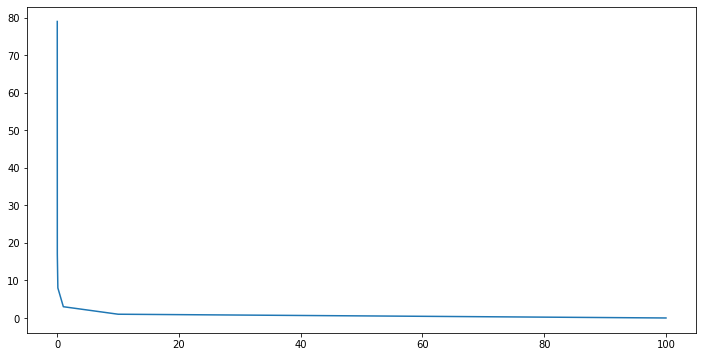

In [15]:
alphas = [.001,.01,.1,1,10,100]
coef_non_zero =[]
for alpha in alphas:
  lasso_model = LassoCV(alphas = [alpha], cv = 5)
  lasso_model.fit(X_train,y)
  coefs = lasso_model.coef_
  coef_num =np.count_nonzero(coefs)
  coef_non_zero.append(coef_num)
plt.plot(alphas, coef_non_zero);
plt.show()

In [16]:
lasso_model = Lasso(alpha = 0.05555)
lasso_model.fit(X_train, y)
y_lasso = lasso_model.predict(X_train)
y_lasso_test = lasso_model.predict(X_test)
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train, y)
y_ridge = ridge_model.predict(X_train)
y_ridge_test = ridge_model.predict(X_test)
X_train_ridge = pd.concat([X_train, pd.DataFrame({"ridge" :y_ridge})], axis = 1)
X_train_ridge = pd.concat([X_train_ridge, pd.DataFrame({"lasso":y_lasso})], axis = 1)
X_test_ridge = pd.concat([X_test, pd.DataFrame({"ridge":y_ridge_test})],axis = 1)
X_test_ridge = pd.concat([X_test_ridge, pd.DataFrame({"lasso":y_lasso_test})], axis = 1)
print(X_train.shape)
print(X_train_ridge.shape)
print(X_test_ridge.shape)
stacked_ridge = RidgeCV()
stacked_ridge.fit(X_train_ridge, y)
print(stacked_ridge.alpha_)
pred_stacked_ridge = stacked_ridge.predict(X_test_ridge)
pred_stacked_ridge = np.expm1(pred_stacked_ridge)
solution_stacked_ridge = pd.DataFrame({"Id":test.Id, "SalePrice":pred_stacked_ridge})
solution_stacked_ridge.to_csv("stacked_ridge_predictions.csv", index=False)
print("the stacked and ensembled method gave a score of 0.12241 when just the final result is np.expm1")
print("the stacked and ensembled method gave a score of 0.13075 when the result of the the first step is np.expm1 ")

(1460, 288)
(1460, 290)
(1459, 290)
10.0
the stacked and ensembled method gave a score of 0.12241 when just the final result is np.expm1
the stacked and ensembled method gave a score of 0.13075 when the result of the the first step is np.expm1 


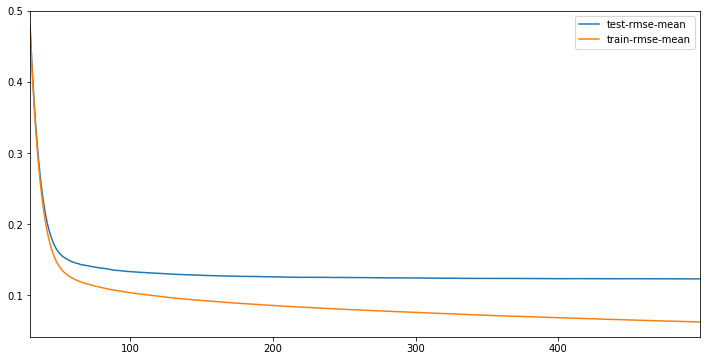

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()


In [18]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric = 'rmse') #the params were tuned using xgb.cv
train_params = {
 "max_depth":[3,4],
 "eta":[.01],
 'n_estimators': [500],
 'min_child_weight':[1,3,5,7],
 'colsample_bytree':[i/10.0 for i in range(6,9)],
 'subsample':[i/10.0 for i in range(6,10)],
 'gamma':[.01,.1,1,5]
}
clf = GridSearchCV(model_xgb,train_params, error_score='rmse')
clf.fit(X_train,y)
clf.best_score_, clf.best_params_


(0.9065224290176,
 {'colsample_bytree': 0.7,
  'eta': 0.01,
  'gamma': 0.01,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 500,
  'subsample': 0.6})

In [19]:
print("rmse: " + str(np.mean(rmse_cv(clf.best_estimator_))) )
print("rmse: " + str(rmse_cv(clf.best_estimator_)) )


rmse: 0.12390445673563436
rmse: [0.10890494 0.14162943 0.1276965  0.11478933 0.12650209]


In [20]:
xgb_preds = np.expm1(clf.best_estimator_.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("xgb_preds.csv", index = False)
print("single xgb gave score of 0.12812")


single xgb gave score of 0.12812


In [21]:
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train, y)
y_ridge = ridge_model.predict(X_train)
y_ridge= pd.DataFrame({"Ridge" : y_ridge})
y_ridge_test = ridge_model.predict(X_test)
y_ridge_test= pd.DataFrame({"Ridge" : y_ridge_test})
y_xgb = pd.DataFrame({"XGB":clf.best_estimator_.predict(X_train)})
y_xgb_test = pd.DataFrame({"XGB":clf.best_estimator_.predict(X_test)})
X_train_xgb = pd.concat([X_train, y_ridge], axis = 1)
X_train_xgb = pd.concat([X_train_xgb, y_xgb], axis = 1)
X_test_xgb = pd.concat([X_test, y_ridge_test], axis = 1)
X_test_xgb = pd.concat([X_test_xgb, y_xgb_test ], axis = 1)
#X_train_xgb = X_train_xgb.loc[:,~X_train_xgb.columns.duplicated()]
#X_test_xgb = X_test_xgb.loc[:,~X_test_xgb.columns.duplicated()]
print(X_train_xgb.shape)
print(X_test_xgb.shape)

(1460, 290)
(1459, 290)


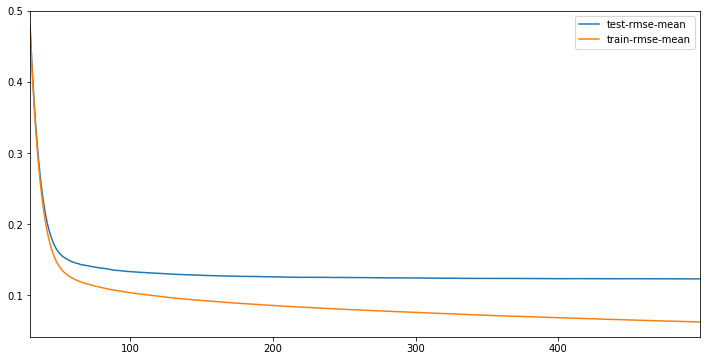

In [22]:
dtrain = xgb.DMatrix(X_train_xgb, label = y)
dtest = xgb.DMatrix(X_test_xgb)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [23]:
model_xgb2 = xgb.XGBRegressor(metrics = 'rmse',objective ='reg:squarederror')
train_params = {"max_depth":[2,3], "eta":[.01,.1], 'n_estimators': [100,200,400,700],'min_child_weight':[1,3,5,7]}
clf = GridSearchCV(model_xgb2,train_params, error_score='rmse')
clf.fit(X_train_ridge,y)
clf.best_score_, clf.best_params_

(0.9237756343219242,
 {'eta': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100})

In [3]:
print("rmse: " + str(np.mean(rmse_cv(clf.best_estimator_))) )

rmse: 0.13533613515712162


In [5]:
xgb_preds = np.expm1(clf.best_estimator_.predict(X_test_xgb))
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("xgb_preds.csv", index = False)
print("rmse: " + str(rmse_cv(model_xgb2)) )

rmse: [0.12500351 0.14537867 0.13669314 0.1309878 0.13861755]


If Ridge Regression did so well, it should be possible to build on top of that to improve its performance.
Attempts to stack the initial xgboost and ridge predictions on the data, then run xgboost can be made but cross-validation must be done to verify rmse.

In [7]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric= 'rmse')
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train, y)
y_ridge = ridge_model.predict(X_train)
y_ridge= pd.DataFrame({"Ridge" : y_ridge})
y_ridge_test = ridge_model.predict(X_test)
y_ridge_test= pd.DataFrame({"Ridge" : y_ridge_test})
y_xgb = y - y_ridge["Ridge"]
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

model_xgb3 = xgb.XGBRegressor(metrics = 'rmse',objective ='reg:squarederror')
train_params = {"max_depth":[2,3], "eta":[.01,.1], 'n_estimators': [100,200,400,700],'min_child_weight':[1,3,5,7]}
clf = GridSearchCV(model_xgb3,train_params, error_score='rmse')
clf.fit(X_train,y_xgb)
clf.best_score_, clf.best_params_

(-0.010647502127993265, {'eta': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100})


In [0]:
y_hat = y_ridge_test["Ridge"] + clf.best_estimator_.predict(X_test)
xgb_preds = np.expm1(y_hat)
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("xgb_preds.csv", index = False)

The idea is to boost on ridge. So after getting the residuals on ridge, train an xgb model on the residuals. Gives score of 0.12923

Helpful links:

"https://www.kaggle.com/ashishbarvaliya/house-price-feature-engineering

"https://www.kaggle.com/miguelrodriguezolmos/predict-house-priceswith-ridge-regression